100%|██████████████████████████████████| 1183/1183 [00:15<00:00, 75.00it/s]


58900480/58889256 [==============================] - 57s 1us/step
Epoch 1/5
158/158 [==============================] - 1779s 11s/step - loss: 0.5975 - accuracy: 0.7622 - val_loss: 0.2263 - val_accuracy: 0.9171
Epoch 2/5
158/158 [==============================] - 1771s 11s/step - loss: 0.1903 - accuracy: 0.9318 - val_loss: 0.1398 - val_accuracy: 0.9497
Epoch 3/5
158/158 [==============================] - 1081s 7s/step - loss: 0.1733 - accuracy: 0.9389 - val_loss: 0.2236 - val_accuracy: 0.9151
Epoch 4/5
158/158 [==============================] - 881s 6s/step - loss: 0.1256 - accuracy: 0.9546 - val_loss: 0.1752 - val_accuracy: 0.9384
Epoch 5/5
158/158 [==============================] - 872s 6s/step - loss: 0.1082 - accuracy: 0.9629 - val_loss: 0.1054 - val_accuracy: 0.9630


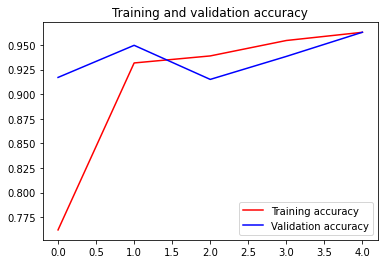

In [2]:
import tensorflow as tf
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense

# Define the path to your image data directory
data_dir = 'C:/Users/ejuma_jrrzjzq/cap-5/Disease-Lukemya'

# Load images from different directories
categories = ['pre', 'pro', 'Early', 'benign']
X = []
y = []

for category in categories:
    path = os.path.join(data_dir, category)
    class_num = categories.index(category)
    for img in tqdm(os.listdir(path)):
        img_array = cv2.imread(os.path.join(path, img))
        img_array = cv2.resize(img_array, (224, 224))
        X.append(img_array)
        y.append(class_num)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encode the labels
num_classes = len(categories)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Load VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom head to the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# Plot training history
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()


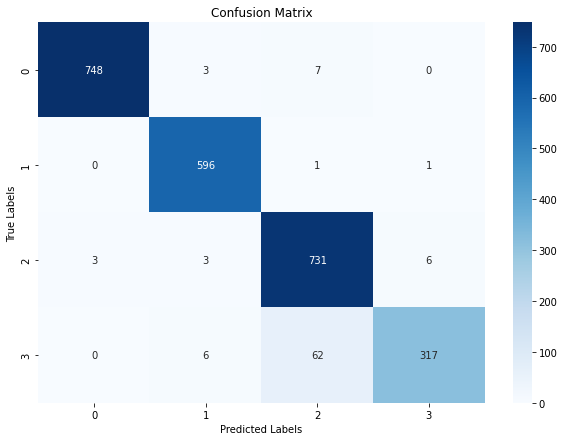

In [7]:
# Import libraries
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on test data
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Print confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Save the model
model.save('my_model.h5')
